In [73]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import pickle
import gymnasium as gym

env = gym.make("Acrobot-v1")

In [74]:
actions = list(range(env.action_space.n))


#definir los bins
cost1_space = np.linspace(-1, 1, 3)
sint1_space = np.linspace(-1, 1, 3)
cost2_space = np.linspace(-1, 1, 3)
sint2_space = np.linspace(-1, 1, 3)
wt1_space = np.linspace(-12, 12, 3)
wt2_space = np.linspace(-28, 28, 3)


In [75]:
def get_state(obs):
    cost1, sint1, cost2, sint2, wt1, wt2 = obs
    cost1_bin = np.digitize(cost1, cost1_space)
    sint1_bin = np.digitize(sint1, sint1_space)
    cost2_bin = np.digitize(cost2, cost2_space)
    sint2_bin = np.digitize(sint2, sint2_space)
    wt1_bin = np.digitize(wt1, wt1_space)
    wt2_bin = np.digitize(wt2, wt2_space)
    return (cost1_bin, sint1_bin, cost2_bin, sint2_bin, wt1_bin, wt2_bin)


In [76]:
class AcroBotAgent:
    def __init__(
        self,
        initial_learning_rate: float,
        learning_rate_decay: float,
        final_learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        self.lr = initial_learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.final_learning_rate = final_learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []
        self.actions = list(range(env.action_space.n))
        self.Q = np.zeros((len(cost1_space)+1, len(sint1_space)+1, len(cost2_space)+1, len(sint2_space)+1, len(wt1_space)+1, len(wt2_space)+1, len(actions)))

    def get_state(self, obs):
        cost1, sint1, cost2, sint2, wt1, wt2 = obs
        cost1_bin = np.digitize(cost1, cost1_space)
        sint1_bin = np.digitize(sint1, sint1_space)
        cost2_bin = np.digitize(cost2, cost2_space)
        sint2_bin = np.digitize(sint2, sint2_space)
        wt1_bin = np.digitize(wt1, wt1_space)
        wt2_bin = np.digitize(wt2, wt2_space)
        return (cost1_bin, sint1_bin, cost2_bin, sint2_bin, wt1_bin, wt2_bin)

    def get_action(self, obs):
        state = self.get_state(obs)
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return int(np.argmax(self.Q[state]))

    def update(self, obs, action, reward, terminated, next_obs):
        state = self.get_state(obs)
        next_state = self.get_state(next_obs)
        future_q_value = (not terminated) * np.max(self.Q[next_state])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.Q[state][action]
        )
        self.Q[state][action] += self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
        self.lr =  max(self.final_learning_rate, self.lr - self.learning_rate_decay)


In [77]:
# hyperparameters
n_episodes = 5_000

initial_learning_rate = 1
learning_rate_decay = initial_learning_rate / (n_episodes / 2)  # reduce learning rate over time
final_learning_rate = 0.001

start_epsilon = 1
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001

agent = AcroBotAgent(
    initial_learning_rate=initial_learning_rate,
    learning_rate_decay=learning_rate_decay,
    final_learning_rate=final_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [78]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [02:08<00:00, 38.89it/s] 


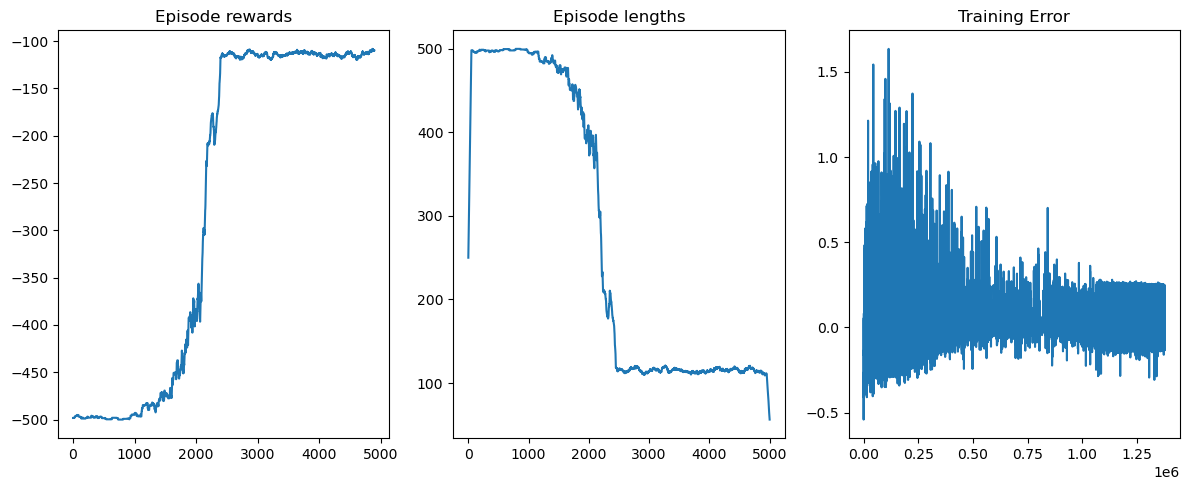

In [79]:
rolling_length = 100
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [80]:
# serialize q values
file = open('4lr.pkl', 'wb')
pickle.dump(agent.Q, file)
file.close()